In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

In [2]:
import chardet

path = '/Users/anaxsouza/Documents/GitKraken/autologistics/dataset_natura_fixed.csv'

with open(path, 'rb') as file:
    result = chardet.detect(file.read())  # Detect encoding
df = pd.read_csv(path, encoding=result['encoding'], engine='python', on_bad_lines='warn')

df

,codigo_do_material,codigo_de_venda,descrição_do_material,peso_liquido,peso_bruto,comprimento,largura,altura,volume_x
0,50001073,1342.0,REVELAR DE NATURA-DESOD COLONIA,86.280,299.092,63.0,51.0,186.0,597.6
1,50024236,5792.0,M&B-MOCHILA TROCADOR X,1.000,148,270.0,530.0,30.0,4293
2,50026386,14509.0,HORUS-DESOD COLONIA 100 ML X,84.300,308.245,78.5,37.5,144.0,424
3,50030504,8155.0,KAIAK-RF MASC DESOD SPRAY CODBARRA,91.300,108.346,61.0,23.0,117.0,164.15
4,50030527,8169.0,BIOGRAFIA-RF MASC DESOD SPRAY CODBARRA,90.800,108.904,61.0,23.0,117.0,164.15
...,...,...,...,...,...,...,...,...,...
24484,50025632,6148.0,NATURA BR-SH CAB DAN ANDIROBA LATAM,412.200,470,56.7,56.7,215.3,692.166
24485,50025631,6147.0,NATURA BR-SH CAB CLAROS CAMOMILA,412.200,470,56.7,56.7,215.3,692.166
24486,50025178,5957.0,DUE-DESOD COL MASC 75 ML LATAM,64.125,303.8,55.0,53.0,135.0,393.525
24487,50001312,1482.0,HIG ORAL- CREME DENTAL REM ERVAS FRESCAS,120.000,144.285,49.0,36.0,179.0,315.76


In [4]:
from skimpy import skim

df_adj = df.drop(['codigo_do_material','codigo_de_venda', 'descrição_do_material'], axis=1) # Remove Material Code

# Function to convert columns with numeric strings with periods as thousand separators
def convert_to_float(column):
    try:
        # Replace periods with nothing
        return pd.to_numeric(column.replace('.', ''), errors='coerce')
    except Exception as e:
        print(f"Failed to convert: {e}")
        return column

# Apply the conversion to each column
df_adj = df_adj.apply(lambda column: convert_to_float(column) if column.dtype == 'object' else column)

skim(df)
skim(df_adj)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 24489  │ │ float64     │ 5     │                                                          │
│ │ Number of columns │ 9      │ │ string      │ 3     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃    ┃      ┃          ┃        ┃          ┃          ┃          ┃          ┃          ┃        ┃  │
│ ┃ e          ┃ NA ┃ NA % ┃ mean     ┃ sd     ┃ p0       ┃ p25      ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ codigo_do_ │  0 │    0 │ 50000000 │ 120000 │ 50000000 │ 50000000 │ 50000000 │ 50000000 │ 51000000 │ ▁▆▇▆▃▅ │  │
│ │ material   │    │      │          │        │          │          │          │          │          │        │  │
│ │ codigo_de_ │  6 │ 0.02 │    76000 │  41000 │        0 │    44000 │    69000 │   100000 │   170000 │ ▃▇▇▅▃▂ │  │
│ │ venda      │    │      │          │        │          │          │          │          │          │        │  │
│ │ peso_liqui │  1 │    0 │       92 │    160 │        0 │      2.5 │       30 │      120 │     3900 │   ▇    │  │
│ │ do         │    │      │          │        │          │          │          │          │          │        │  │
│ │ compriment │  0 │    0 │      110 │    140 │        0 │       44 │       70 │      140 │     6000 │   ▇    │  │
│ │ o          │    │      │          │        │          │          │          │          │          │        │  │
│ │ largura    │  0 │    0 │       68 │     85 │        0 │       24 │       44 │       76 │     4900 │   ▇    │  │
│ │ altura     │  0 │    0 │       93 │     92 │    0.001 │       32 │       85 │      140 │     3700 │   ▇    │  │
│ └────────────┴────┴──────┴──────────┴────────┴──────────┴──────────┴──────────┴──────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                           ┃ NA    ┃ NA %      ┃ words per row            ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ descrição_do_material                 │     0 │         0 │                      6.3 │              154014 │  │
│ │ peso_bruto                            │     0 │         0 │                        1 │               24489 │  │
│ │ volume_x                              │     0 │         0 │                        1 │               24489 │  │
│ └───────────────────────────────────────┴───────┴───────────┴──────────────────────────┴─────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 24489  │ │ float64     │ 6     │                                                          │
│ │ Number of columns │ 6      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA    ┃ NA %   ┃ mean   ┃ sd       ┃ p0      ┃ p25  ┃ p50  ┃ p75  ┃ p100       ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ peso_liquido     │     1 │      0 │     92 │      160 │       0 │  2.5 │   30 │  120 │       3900 │   ▇    │  │
│ │ peso_bruto       │     7 │   0.03 │    160 │      230 │       0 │   22 │   96 │  240 │       8100 │   ▇    │  │
│ │ comprimento      │     0 │      0 │    110 │      140 │       0 │   44 │   70 │  140 │       6000 │   ▇    │  │
│ │ largura          │     0 │      0 │     68 │       85 │       0 │   24 │   44 │   76 │       4900 │   ▇    │  │
│ │ altura           │     0 │      0 │     93 │       92 │   0.001 │   32 │   85 │  140 │       3700 │   ▇    │  │
│ │ volume_x         │   212 │   0.87 │   6300 │   360000 │   0.001 │   54 │  240 │  530 │   44000000 │   ▇    │  │
│ └──────────────────┴───────┴────────┴────────┴──────────┴─────────┴──────┴──────┴──────┴────────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

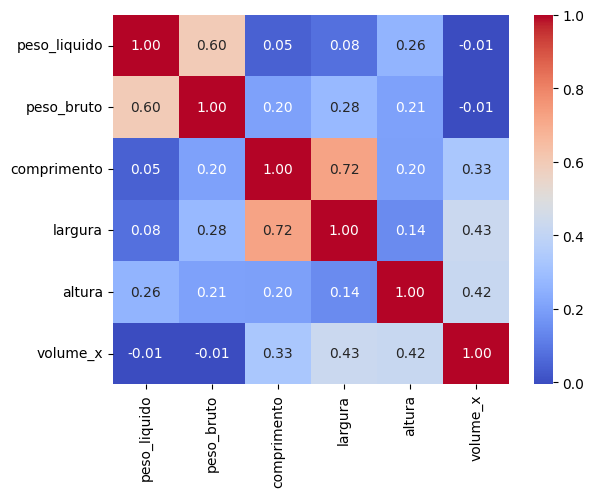

In [6]:
# Compute the correlation matrix
corr = df_adj.corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
#plt.savefig('correlation_heatmap.png')

In [9]:
cols  = list(df_adj.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_adj)
scaled_df = scaler.transform(df_adj)
scaled_df = pd.DataFrame(scaled_df, columns=cols)

In [12]:
scaled_df

,peso_liquido,peso_bruto,comprimento,largura,altura,volume_x
0,0.022123,0.036925,0.010588,0.010451,0.050270,0.000013
1,0.000256,0.018272,0.045378,0.108607,0.008108,0.000097
2,0.021615,0.038055,0.013193,0.007684,0.038919,0.000010
3,0.023410,0.013376,0.010252,0.004713,0.031621,0.000004
4,0.023282,0.013445,0.010252,0.004713,0.031621,0.000004
...,...,...,...,...,...,...
24484,0.105692,0.058025,0.009529,0.011619,0.058189,0.000016
24485,0.105692,0.058025,0.009529,0.011619,0.058189,0.000016
24486,0.016442,0.037506,0.009244,0.010861,0.036486,0.000009
24487,0.030769,0.017813,0.008235,0.007377,0.048378,0.000007


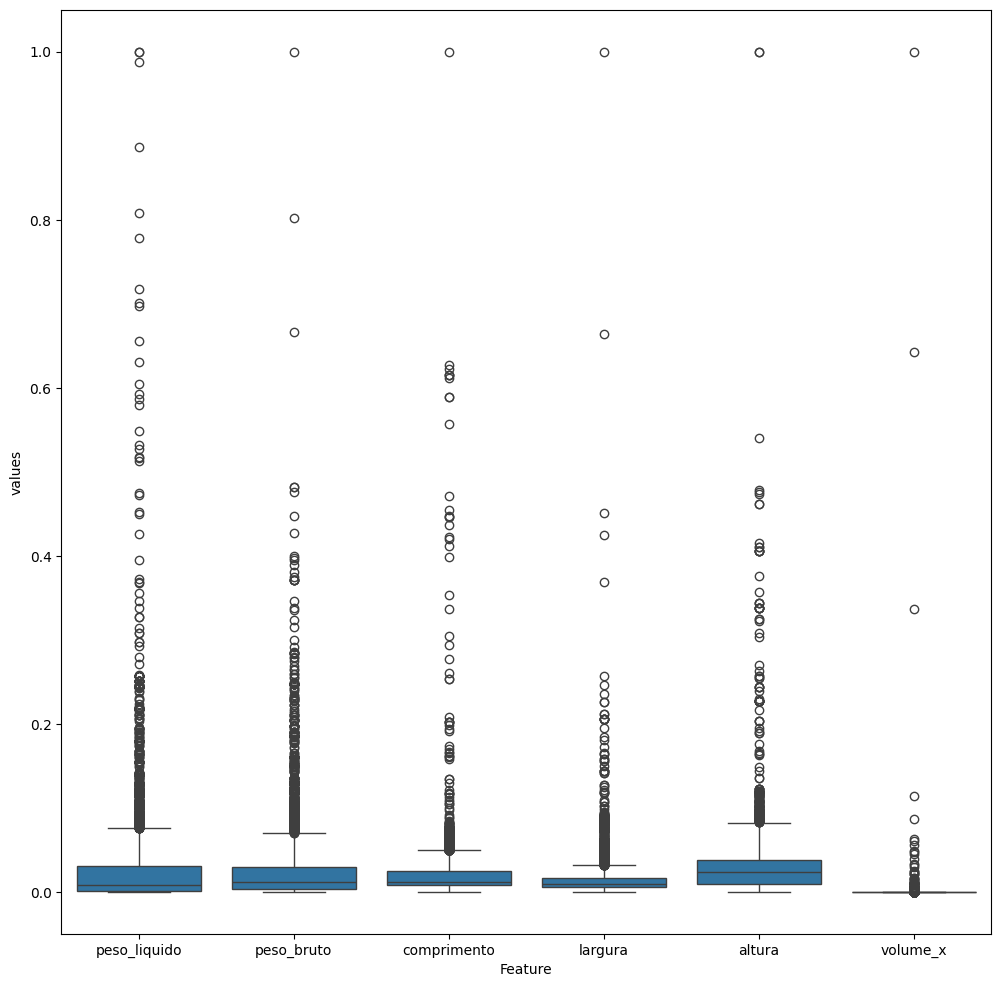

In [26]:
dfs = []
for i in cols:
    tmp = pd.DataFrame(scaled_df[i])
    tmp.rename(columns={i: 'values'}, inplace=True)
    tmp['Feature'] = i
    dfs.append(tmp)

# Concatenate and reset index
data = pd.concat(dfs).reset_index(drop=True)

# Now create the boxplot
sns.boxplot(x="Feature", y="values", data=data)
fig = plt.gcf()
fig.set_size_inches(12, 12)
#fig.savefig('1.png')

In [21]:
data.reset_index(inplace=True)
data

,index,values,Feature
0,0,0.022123,peso_liquido
1,1,0.000256,peso_liquido
2,2,0.021615,peso_liquido
3,3,0.023410,peso_liquido
4,4,0.023282,peso_liquido
...,...,...,...
146929,146929,0.000016,volume_x
146930,146930,0.000016,volume_x
146931,146931,0.000009,volume_x
146932,146932,0.000007,volume_x


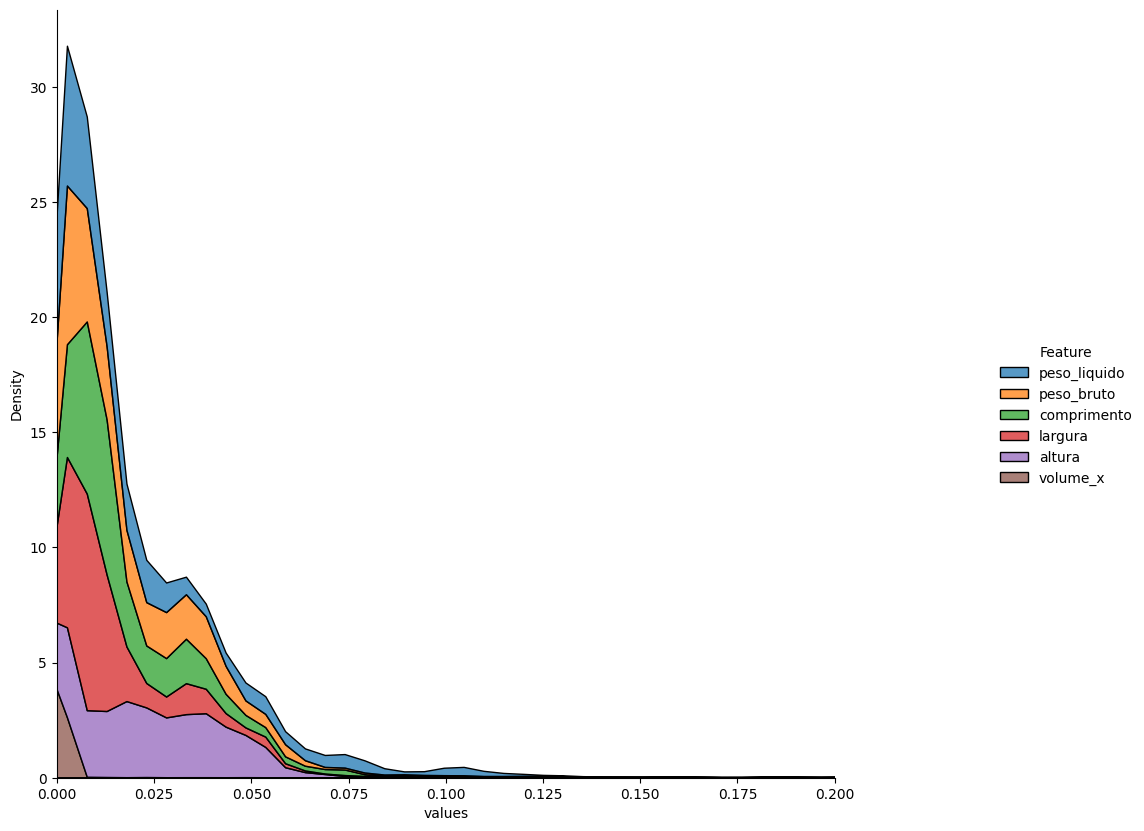

In [27]:
#sns.displot(data, x="values", hue="Feature", kind="kde", fill=True)
sns.displot(data, x="values", hue="Feature", kind="kde", multiple="stack")
fig = plt.gcf()
fig.set_size_inches(12, 9)
plt.xlim(0, 0.2)  # Set the upper limit of x-axis to 0.2
#fig.savefig('2.png')

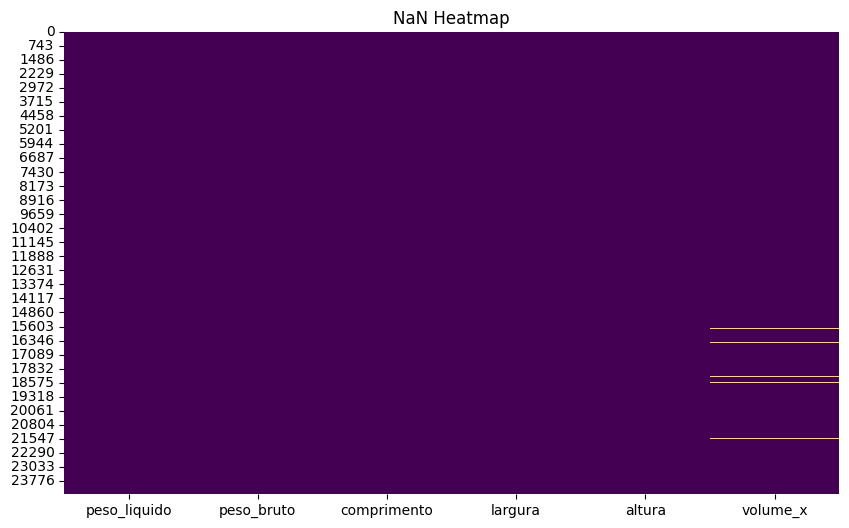

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap to visualize the NaN values in each column
plt.figure(figsize=(10, 6))
sns.heatmap(df_adj.isna(), cbar=False, cmap='viridis')
plt.title('NaN Heatmap')
plt.show()


In [53]:
def cluster(data, npc=0, k=2):
    print(f"Starting clustering with npc={npc} and k={k}")
    
    # Handling NaN values
    initial_row_count = data.shape[0]
    clean_data = data.dropna()  # Drop rows with NaNs
    print(f"Dropped {initial_row_count - clean_data.shape[0]} rows due to NaNs.")
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(clean_data)
    scaled = scaler.transform(clean_data)

    if npc != 0:
        pca = PCA(n_components=npc)
        pca.fit(scaled)
        scaled = pca.transform(scaled)
        print(f"PCA complete. Explained variance ratio sum: {pca.explained_variance_ratio_.sum():.4f}")

    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled)
    sc = silhouette_score(scaled, kmeans.labels_)
    print(f"Silhouette score for k={k} with npc={npc}: {sc:.4f}")

    return sc, kmeans.labels_, clean_data.index  # Return the index of the cleaned data

def automagic():
    n_pcs = [0, 2, 3]
    ks = [i for i in range(2, 10)]
    scores = []
    n_PC = []
    Ks = []
    
    for i in n_pcs:
        for j in ks:
            print(f"Evaluating for {i} PCs and {j} clusters.")
            score, _, _ = cluster(df_adj, npc=i, k=j)  # Adjusted to unpack three values
            scores.append(score)
            n_PC.append(i)
            Ks.append(j)
    
    table = pd.DataFrame({
        'Ks': Ks,
        'PCs': n_PC,
        'Score': scores
    })
    table['PCs'] = table['PCs'].replace(0, 'No')
    
    sns.lineplot(data=table, x='Ks', y='Score', hue='PCs', palette=sns.color_palette(n_colors=3))
    plt.grid()
    fig = plt.gcf()
    fig.set_size_inches(8, 5)
    #fig.savefig('results.png')
    print("Plot saved as 'results.png'.")
    
    return table

Evaluating for 0 PCs and 2 clusters.
Starting clustering with npc=0 and k=2
Dropped 217 rows due to NaNs.
Silhouette score for k=2 with npc=0: 0.8018
Evaluating for 0 PCs and 3 clusters.
Starting clustering with npc=0 and k=3
Dropped 217 rows due to NaNs.
Silhouette score for k=3 with npc=0: 0.3575
Evaluating for 0 PCs and 4 clusters.
Starting clustering with npc=0 and k=4
Dropped 217 rows due to NaNs.
Silhouette score for k=4 with npc=0: 0.4282
Evaluating for 0 PCs and 5 clusters.
Starting clustering with npc=0 and k=5
Dropped 217 rows due to NaNs.
Silhouette score for k=5 with npc=0: 0.4225
Evaluating for 0 PCs and 6 clusters.
Starting clustering with npc=0 and k=6
Dropped 217 rows due to NaNs.
Silhouette score for k=6 with npc=0: 0.4137
Evaluating for 0 PCs and 7 clusters.
Starting clustering with npc=0 and k=7
Dropped 217 rows due to NaNs.
Silhouette score for k=7 with npc=0: 0.4191
Evaluating for 0 PCs and 8 clusters.
Starting clustering with npc=0 and k=8
Dropped 217 rows due to 

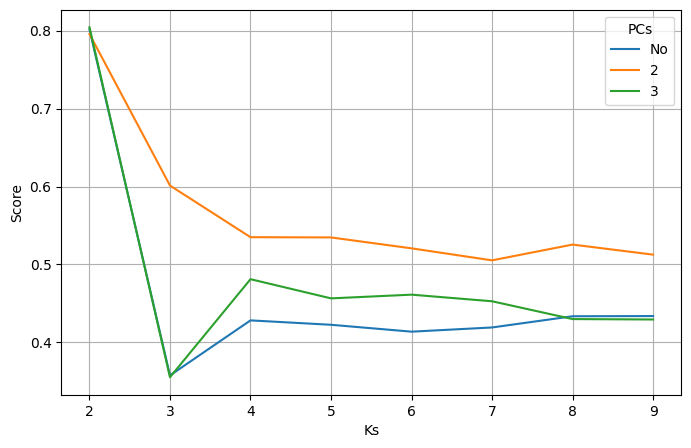

In [54]:
results = automagic()

Starting clustering with npc=3 and k=2
Dropped 217 rows due to NaNs.
PCA complete. Explained variance ratio sum: 0.8670
Silhouette score for k=2 with npc=3: 0.8045


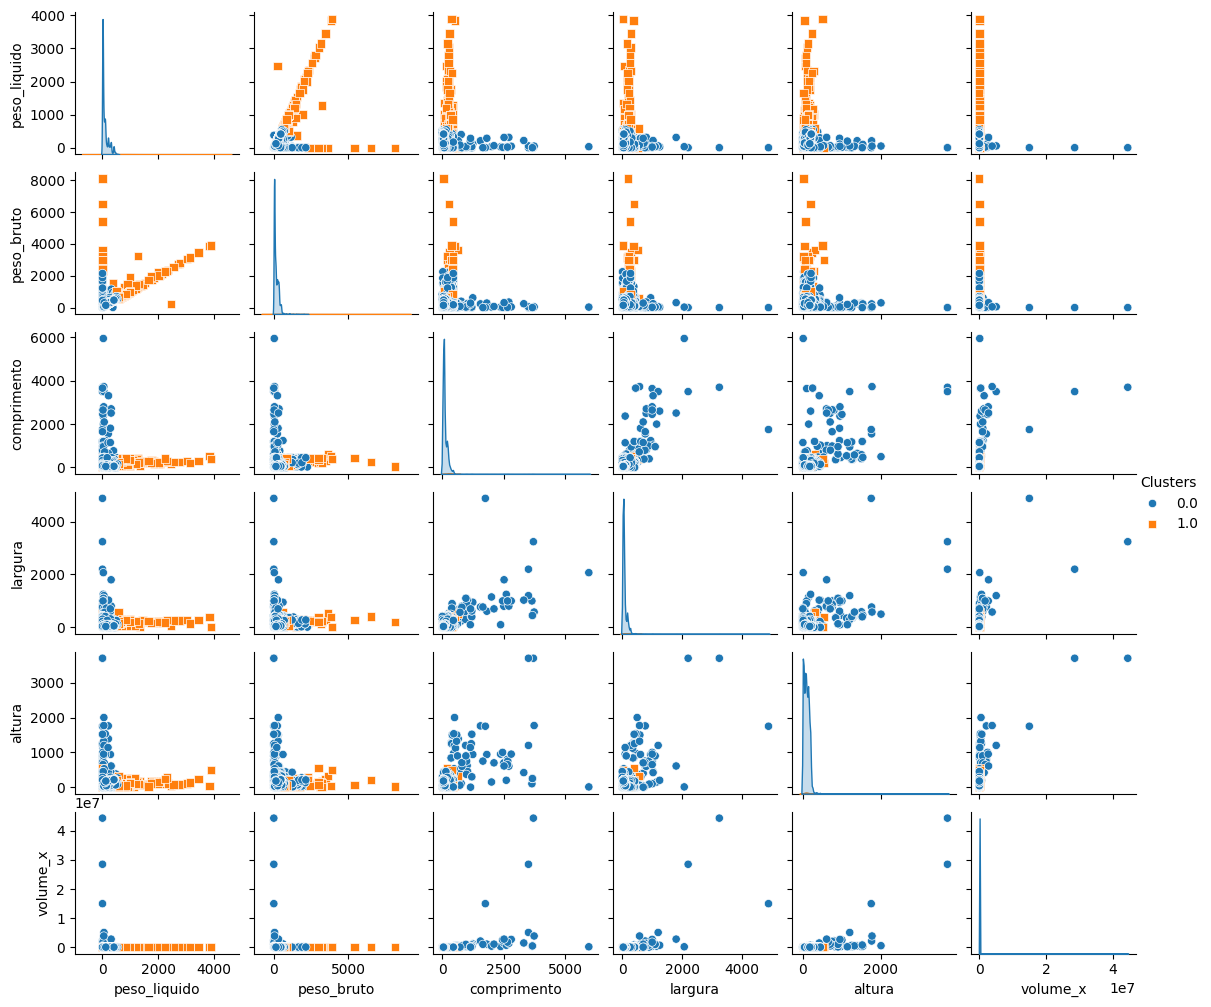

In [61]:
# Corrected unpacking to handle all returned values from cluster
_, labels, clean_index = cluster(df_adj, npc=3, k=2)

# Use the clean_index to correctly align the labels with your original DataFrame
df_adj.loc[clean_index, 'Clusters'] = labels  # Assign labels to the DataFrame based on the index

# Now proceed with your plotting or other data analysis tasks
unique_clusters = df_adj['Clusters'].nunique()  # Get the unique number of clusters

# Define colors and markers, ensuring they match the number of clusters
colors = sns.color_palette(n_colors=unique_clusters)
markers = ["o", "s", "D", "v", "^"][:unique_clusters]

# Create the pairplot
sns.pairplot(df_adj.dropna(subset=['Clusters']), hue='Clusters', palette=colors, markers=markers)
fig = plt.gcf()
fig.set_size_inches(12, 10)
#fig.savefig('final_clustering.png')

In [64]:
scaled_df['Clusters'] = df_adj['Clusters']

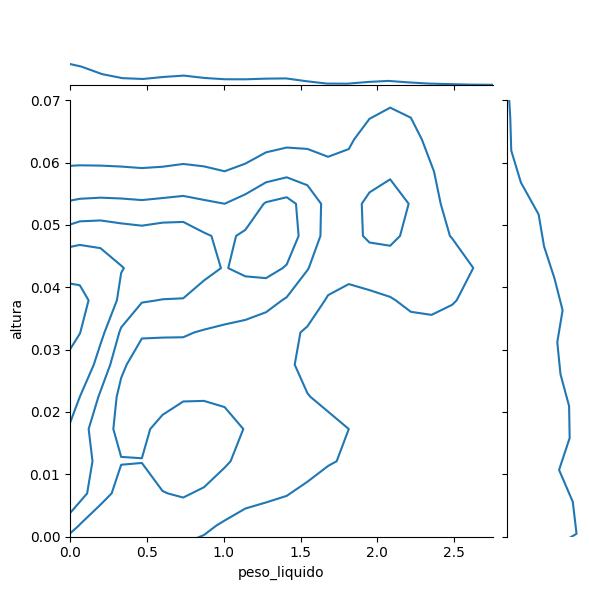

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the jointplot with limited axes
sns.jointplot(
    data=scaled_df,
    x="peso_liquido", y="altura", 
    kind="kde", 
    xlim=(0, 2.75), ylim=(0, 0.07)  # Limiting the x and y axes
)

# Saving the plot
#plt.savefig('jointplot.png', dpi=500)

# Optionally, display the plot
plt.show()
